# Lab for answering question C
Responsible: Moritz Renkin
Question: Are there trends visible that could be due to climate change?

In [86]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%run -i utility_functions.py

Loading the files from the transformation notebook

In [87]:
transformed_df_serial_path = "../data/data_transformed.pickle"

with open(transformed_df_serial_path, "rb") as file:
    df: pd.DataFrame = pickle.load(file)

assert isinstance(df, pd.DataFrame),f"The serialized object in {transformed_df_serial_path} is not a pandas dataframe!"
assert len(df)!=0, "The serialized dataframe contains no data!"


with open("../data/country_temp_delta.pickle", "rb") as file:
    country_temp_delta: pd.DataFrame = pickle.load(file)

Loading the disaster classification

In [88]:
disaster_classification: pd.DataFrame = pd.read_csv("../data/disaster_classification.csv")
disaster_subgroups = set(disaster_classification.loc[disaster_classification["Disaster Sub-Group"].notna(), "Disaster Sub-Group"])

Loading the NASA yearly global temperature data, source: [https://climate.nasa.gov/vital-signs/global-temperature/](https://climate.nasa.gov/vital-signs/global-temperature/)

In [89]:
yearly_global_temp: pd.DataFrame = pd.read_csv("../data/nasa_yearly_global_temperature.csv", index_col="Year").rename(columns={"Temp_No_Smoothing": "Temperature Delta"})
yearly_global_temp

,Temperature Delta,Temp_Lowess(5)
Year,,
1880,-0.18,-0.10
1881,-0.09,-0.14
1882,-0.11,-0.17
1883,-0.17,-0.20
1884,-0.28,-0.24
...,...,...
2017,0.92,0.91
2018,0.85,0.92
2019,0.98,0.93


Dumping all data before 1950 as it is not relevant to climate change.

In [90]:
cutoff_year = 1950 # TODO check
df = df[df["Start_Year"] >= cutoff_year]
min_year = df["Start_Year"].min()
max_year = df["Start_Year"].max()

yearly_global_temp = yearly_global_temp[yearly_global_temp.index >= cutoff_year]

Dumping extra-terrestrial and geophysical disasters can be assumed to be indifferent to climate change

In [91]:
df = df[(df["Disaster_Subgroup"] != "Extra-terrestrial") & (df["Disaster_Subgroup"] != "Geophysical")]

## Get Yearly Deaths

Read the documentation in utility_functions.py for info on parameters etc.

In [92]:
get_yearly_deaths(df, include_zero=True).to_frame() # Deaths grouped by year. Rows with zero deaths can be excluded

,Total_Deaths
Year,
1950,4811.0
1951,8688.0
1952,6504.0
1953,10089.0
1954,38491.0
...,...
2018,7840.5
2019,23556.166667
2020,15461.166667


In [93]:
get_yearly_deaths(df, custom_index=["Country", "Disaster_Subtype"], include_zero=False).to_frame() # Deaths can be grouped by year and each of custom_index

Total_Deaths
Year Country                            Disaster_Subtype              
1950 Antigua and Barbuda                Tropical cyclone           2.0
     India                              Riverine flood            45.0
     Japan                              Tropical cyclone         509.0
     Pakistan                           Riverine flood          2900.0
     Peru                               Landslide                130.0
...                                                                ...
2022 Venezuela (Bolivarian Republic of) Landslide                109.0
     Viet Nam                           Convective storm          11.0
                                        Tropical cyclone          19.0
     Yemen                              Flash flood               13.0
     Zimbabwe                           Viral disease            750.0

[5781 rows x 1 columns]

## Regarding Groupby and Pandas Datatypes

Pandas usually uses numpy datatypes. However, **numpy integer arrays do not allow for null values (np.nan)**. That's why pandas introduces their own Integer array, which can inlcude null values (pd.NA). However, for groupby operations these pd.NA values can cause problems, so it is advisable to convert back to a numpy float array (which does allow for np.nan) before applying the groupby.

In [94]:
series = pd.Series(np.arange(10)) # just for demonstration

series.astype("int32") # <-- "int32" (small i) = numpy int, no empty values
series.astype("Int32") # <-- "Int32" (big i) = pandas int, allows empty values (pd.NA)
series.astype("float32") # <-- numpy float, allows empty values (np.nan)
pass

In [95]:
groupby_base = df.astype({"Total_Deaths": np.float64, "Total_Affected": np.float64, "Start_Year": np.int32, "Disaster_Decade": np.int32})
groupby_base = groupby_base[groupby_base["Disaster_Decade"] < 2020]
groupby_base[["Disaster_Subgroup", "Total_Deaths"]].groupby(["Disaster_Subgroup"]).mean()

,Total_Deaths
Disaster_Subgroup,
Biological,215.214689
Climatological,9342.864979
Hydrological,554.114710
Meteorological,332.690490


## Data Exploration

In [96]:
year_range = range(min_year, max_year)

def fill_missing_year():
    set(groupby_base.groupby("Start_Year").size().rename("No_Disasters").index).difference(year_range)
    # TODO



Text(0.5, 0, 'Year AC.')

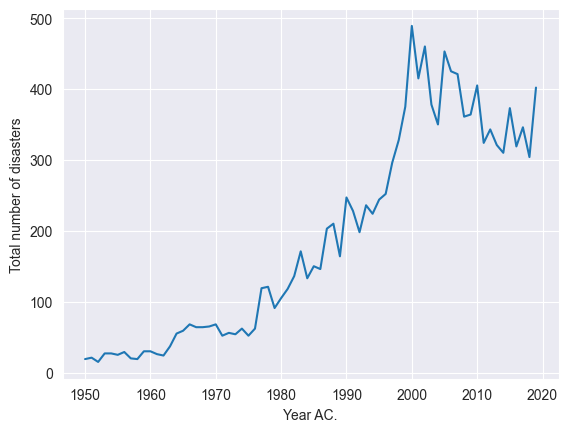

In [97]:
total_disaster_per_year = get_yearly_disaster_count(groupby_base, include_zero=True)
plt.plot(total_disaster_per_year.index, total_disaster_per_year)
plt.ylabel("Total number of disasters")
plt.xlabel("Year AC.")

<AxesSubplot: xlabel='Disaster_Decade', ylabel='No_Disasters'>

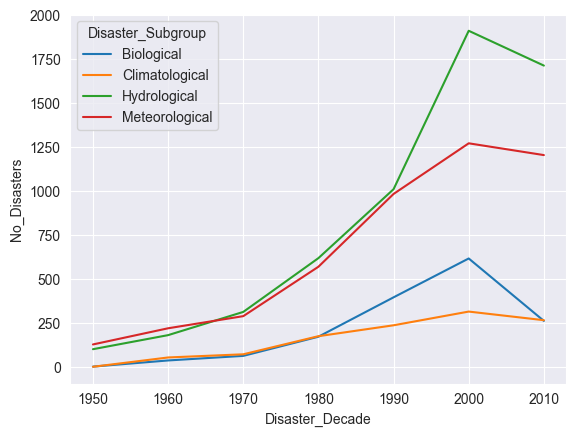

In [98]:
sns.lineplot(data=get_yearly_disaster_count(groupby_base, index_cols=["Disaster_Decade","Disaster_Subgroup"]).reset_index(),
             x="Disaster_Decade",
             y="No_Disasters",
             hue="Disaster_Subgroup")

<AxesSubplot: xlabel='Start_Year', ylabel='No_Disasters'>

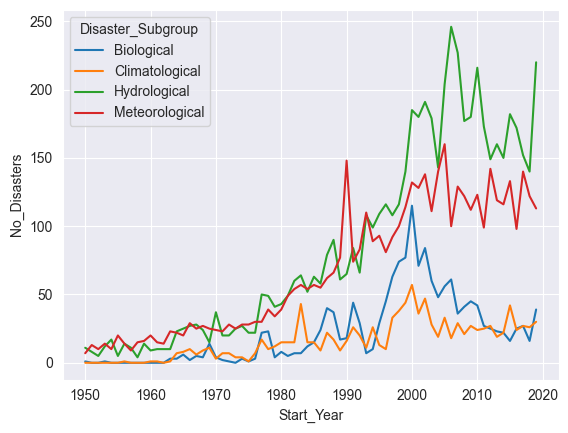

In [99]:
# disaster_subgroup = disaster_classification["Disaster Sub-Group"]
sns.lineplot(data=get_yearly_disaster_count(groupby_base, index_cols=["Start_Year","Disaster_Subgroup"]).reset_index(),
             x="Start_Year",
             y="No_Disasters",
             hue="Disaster_Subgroup")

<AxesSubplot: xlabel='Start_Year', ylabel='No_Disasters'>

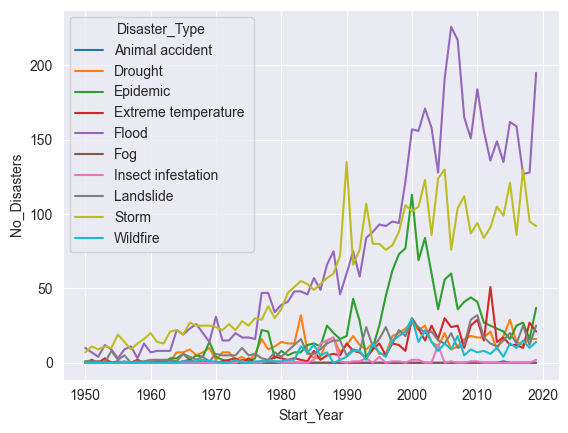

In [107]:
sns.lineplot(data=get_yearly_disaster_count(groupby_base, index_cols=["Start_Year","Disaster_Type"]).reset_index(),
             x="Start_Year",
             y="No_Disasters",
             hue="Disaster_Type")

## Trends in the global number of Disasters
### Number of total Disasters


Correlation coefficient: 0.8886333511376328


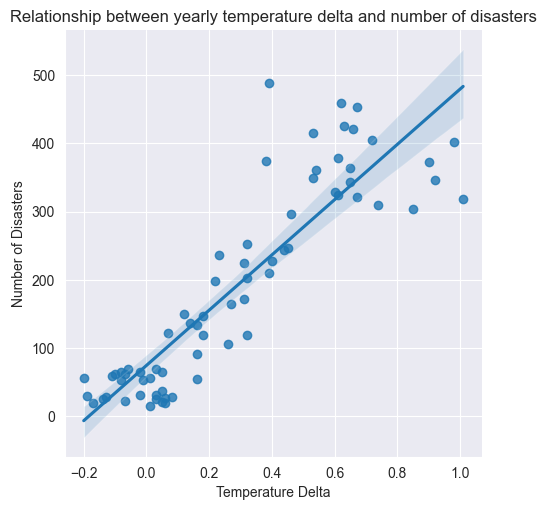

In [101]:
yearly_temp_disasters = pd.concat((yearly_global_temp, get_yearly_disaster_count(groupby_base)), axis="columns")#.rename_axis("Year")
yearly_temp_disasters["Disaster_Decade"] = yearly_temp_disasters.index//10*10
sns.lmplot(data=yearly_temp_disasters, x="Temperature Delta", y="No_Disasters")
plt.xlabel("Temperature Delta")
plt.ylabel("Number of Disasters")
plt.title("Relationship between yearly temperature delta and number of disasters")
print(f"Correlation coefficient: {yearly_temp_disasters['Temperature Delta'].corr(yearly_temp_disasters['No_Disasters'])}")

In the graph above, a linear regression is depicted to show the supposed impact of rising temperatures on the number of natural disaster occurrences. Specially, the linear regression is performed on the global temperature delta of a given year to long-term average (x-axis) and the Number of natural disasters in that year (y-axis).

Text(0.5, 1.0, 'Relationship between decade-wise temperature delta and change-rate of disaster occurrences')

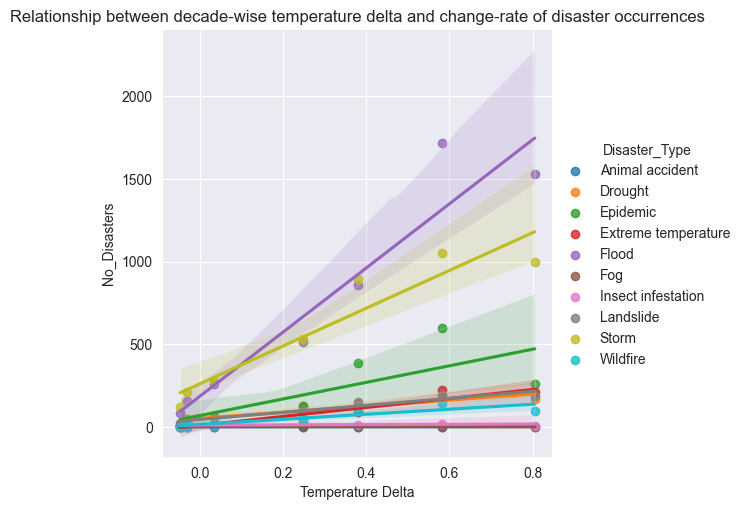

In [102]:
yearly_disaster_temp_by_subgroup = get_yearly_disaster_count(groupby_base, index_cols=["Disaster_Decade","Disaster_Type"]).to_frame()
yearly_disaster_temp_by_subgroup["Temperature Delta"] = 0
yearly_disaster_temp_by_subgroup["Temperature Delta"] = yearly_disaster_temp_by_subgroup["Temperature Delta"].add(yearly_temp_disasters.groupby("Disaster_Decade")["Temperature Delta"].mean().drop(2020))
yearly_disaster_temp_by_subgroup.reset_index(inplace=True)

sns.lmplot(data=yearly_disaster_temp_by_subgroup,
           x="Temperature Delta",
           y="No_Disasters",
           hue="Disaster_Type")
plt.title("Relationship between decade-wise temperature delta and change-rate of disaster occurrences")

Similar to the previous graph, this one tries to show the relationship between increasing temperature and the number of disaster occurrences. For this graphic, though, the regression is performed for each disaster type independently. The **relative** change in occurrences to the first decade (1950) is used in order to identify the strongest trends in connection to the temperature delta.
Disaster type "Flood" and "Storm" have the steepest slope which corresponds to their linear regression coefficients.

## Country-specific trends due to temperature increase

In [103]:
yearly_country_disasters = get_yearly_disaster_count(groupby_base, index_cols=["Start_Year", "Country"], include_zero=True).reset_index()
countrywise_year_disastercount_correlation = yearly_country_disasters.groupby('Country')[["Start_Year", "No_Disasters"]].corr().iloc[0::2,-1].reset_index(level=1, drop=True).rename("Year-DisasterCount Correlation")

In [104]:
countries_complete = pd.concat((country_temp_delta, countrywise_year_disastercount_correlation), axis="columns", join="inner")
countries_complete

,Region,Warming/Century,Uncertainty (±),Year-DisasterCount Correlation
Country,,,,
Afghanistan,Asia,3.32,0.34,0.710709
Albania,Europe,1.97,0.28,0.496305
Algeria,Africa,2.86,0.28,0.437044
American Samoa,NaN,1.43,0.57,0.122167
Angola,Africa,1.61,0.34,0.662275
...,...,...,...,...
Uruguay,South America,1.56,0.45,0.551514
Uzbekistan,Asia,2.72,0.29,0.194946
Yemen,Asia,2.50,0.55,0.637231


Correlation coefficient: -0.10089168045308464


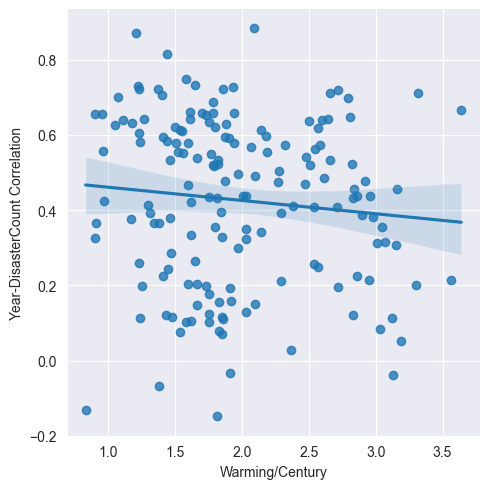

In [112]:
sns.lmplot(data=countries_complete,
           x="Warming/Century",
           y="Year-DisasterCount Correlation")
print(f"Correlation coefficient: {countries_complete['Warming/Century'].corr(countries_complete['Year-DisasterCount Correlation'])}")

Backup

In [106]:
first_year_index = tuple(no_disasters_per_type_and_year[min_year].index)

missing_from_first = disaster_subgroups.difference(first_year_index)
no_disasters_per_type_and_year.add(
    pd.Series(
        data=np.zeros(len(missing_from_first)),
        index=pd.MultiIndex.from_tuples([(min_year, subgroup) for subgroup in missing_from_first])))


NameError: name 'no_disasters_per_type_and_year' is not defined